In [1]:
import os
import cv2
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
def show_image_and_mask(dataset, idx):
    image, target_dict = dataset[idx]
    image = image
    mask = target_dict['masks'][0].numpy()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Mask')
    plt.show()

In [3]:
def show_image_with_bbox(dataset, idx):
    image, target_dict = dataset[idx]
    bbox = target_dict['boxes'][0].numpy()
    xmin, ymin, xmax, ymax = bbox

    plt.imshow(image, cmap='gray')
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2))
    plt.title('Image with Bounding Box')
    plt.show()

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
class SketchDataset(Dataset):
    def __init__(self, image_dir, target_dir, transform=None):
        self.image_dir = image_dir
        self.target_dir = target_dir
        self.transform = transform
       
        self.images = sorted([img for img in os.listdir(image_dir) if img.endswith('.png')])
        self.targets = sorted([tgt for tgt in os.listdir(target_dir) if tgt.endswith('.png')])

        assert len(self.images) == len(self.targets), "The number of images and targets must be the same"
        assert all(img.split('.')[0] == tgt.split('.')[0] for img, tgt in zip(self.images, self.targets)), "Image and target filenames must match"

    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])

        target_path = os.path.join(self.target_dir, self.images[idx])
        
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        target = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)

        if image is None or target is None:
            raise RuntimeError(f"Failed to load image or target at index {idx}")
        
        
        target[target != 0] = 1  # Convert to binary mask

        bbox = self.get_bounding_box(target)

        # Convert bbox from (xmin, ymin, xmax, ymax) to [N, 4] tensor
        boxes = torch.as_tensor([bbox], dtype=torch.float32)

        # There is only one class (mask)
        labels = torch.ones((1,), dtype=torch.int64)

        # Convert mask to [N, H, W] tensor
        masks = torch.as_tensor(target, dtype=torch.uint8)
        masks = masks.unsqueeze(0)  # Add an extra dimension for N

        target_dict = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks
        }

        if self.transform:
            image = self.transform(image)

        return image, target_dict

    @staticmethod
    def get_bounding_box(mask):
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]

        return (xmin, ymin, xmax, ymax)

In [6]:
IMAGE_DIR = "../../datasets/sketch-parse/images"
TARGET_DIR = "../../datasets/sketch-parse/masks"

In [7]:
dataset = SketchDataset(
    image_dir=IMAGE_DIR,
    target_dir=TARGET_DIR
)

In [8]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
test_size = dataset_size-train_size
batch_size = 16

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,collate_fn=collate_fn)

In [9]:
def create_maskrcnn_resnet50_fpn():
    num_classes = 2 #Background and object
    
    # Load a model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='COCO_V1')

    # Replace the classifier with a new one for our number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace the mask predictor with a new one for our number of classes
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [10]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
model = create_maskrcnn_resnet50_fpn().to(device)
model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
start_epoch = 3
num_epochs = 6
train_losses = []

checkpoint = torch.load(f"results/model_epoch_{start_epoch}.pth")

model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

for epoch in range(start_epoch, num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0

    for images, targets in train_loader:
        images = list(torch.from_numpy(img.astype(np.float32)).unsqueeze(0).to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss}")

    # Save the model after every epoch
    state = {
        'epoch': epoch + 1,  # next epoch number
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }   
    torch.save(state, f'results/model_epoch_{epoch+1}.pth')

Epoch [4/6], Training Loss: 2.103280108083378
Epoch [5/6], Training Loss: 1.3237646398219196
Epoch [6/6], Training Loss: 23.997277612035926


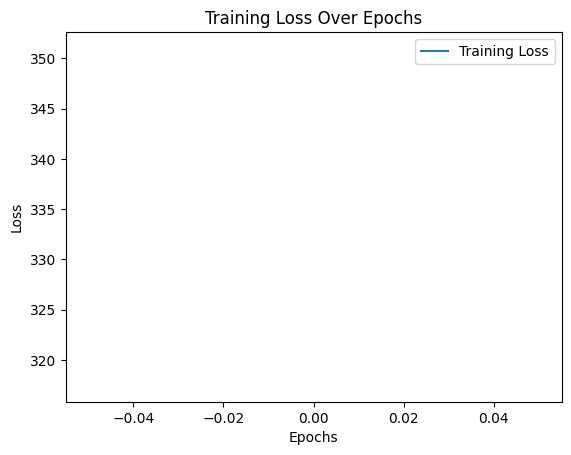

In [14]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()